# Notebook Configuration

## Resume of the results with each model

Given this results, we will train a model with Gradient Boosting Regression with quantile parameter on 90% for data with no null values and XGboost for data with null values, since the proportion of null values is really low and it's the only algorithm that can handle it withouth going deep into why null values are present.

Random Forest regressor

 * 58% of orders will arrive on time or before the estimation time
 * General MAE : 19.5 minutes
 * General MSE : 667
 * Late arrivals MAE : 23.5 minutes

Gradient Boosting Regression with quantile parameter on 90%

 * 89% of orders will arrive on time or before the estimation time
 * General MAE : 1667 minutes
 * General MSE : 36 minutes
 * Late arrivals MAE : 21 minutes

Xtreeme gradient boosting

 * 46% of orders will arrive on time or before the estimation time
 * General MAE : 19 minutes
 * General MSE : 649 
 * Late arrivals MAE : 23 minutes
 
Support vector regressions

 * 45% of orders will arrive on time or before the estimation time
 * General MAE : 18.6 minutes
 * General MSE : 666 
 * Late arrivals MAE : 23.7 minutes

## Declare libraries that i am going to use

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import pandas as pd
pd.set_option("display.max_columns", 30)
import numpy as np
# librerías para graficar
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="white")
import os
from sklearn.model_selection import GridSearchCV, train_test_split,cross_validate
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_pinball_loss
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.linear_model import QuantileRegressor
from sklearn.preprocessing import QuantileTransformer,RobustScaler
from sklearn.svm import SVR
from xgboost import DMatrix,XGBRegressor, train

## declare functions made by me that i am going to use

In [2]:
# función creada por mi para traer los NA's
def get_na(df):
    qsna=df.shape[0]-df.isnull().sum(axis=0)
    qna=df.isnull().sum(axis=0)
    ppna=round(100*(df.isnull().sum(axis=0)/df.shape[0]),2)
    aux= {'datos sin NAs en q': qsna, 'Na en q': qna ,'Na en %': ppna}
    na=pd.DataFrame(data=aux)
    return na.sort_values(by='Na en %',ascending=False)

def train_metrics(X,y,n_cv, metrics, model):
    scores = cross_validate(model, X, y, scoring=metrics, cv=n_cv,return_train_score=False)
    # print scores
    #print('Mean train R2 of the training with cross validation: %.3f (%.3f)' % (scores['train_r2'].mean(), scores['train_r2'].std()) )
    print('Mean test R2 of the training with cross validation: %.3f (%.3f)' % (scores['test_r2'].mean(), scores['test_r2'].std()) )
    #print('Mean train MSE vof the training with cross validation: %.3f (%.3f)' % (scores['train_mse'].mean(), scores['train_mse'].std()) )
    print('Mean test MSE of the training with cross validation: %.3f (%.3f)' % (scores['test_mse'].mean(), scores['test_mse'].std()) )
    #print('Mean train MAE of the training with cross validation: %.3f (%.3f)' % (scores['train_mae'].mean(), scores['train_mae'].std()) )
    print('Mean test MAE of the training with cross validation: %.3f (%.3f)' % (scores['test_mae'].mean(), scores['test_mae'].std()) )
    # plot of train and test scores of the K-folds
    values = np.arange(1,n_cv+1)
    #plt.plot(values, scores['train_mae'], '-o', label='Train MAE of the training with cross validation')
    plt.plot(values, scores['test_mae'], '-o', label='Test MAE of the training with cross validation')
    plt.title('MSE of the training with cross validation in each k-fold')
    plt.legend()
    plt.show()
    return scores

def show_test_metrics(X_train,y_train,y_test,model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(model.score(X_test, y_pred))
    print("This the % of orders that will arrive on time or before the predicted arrival time: {:.4f}".format(sum((y_pred>=y_test))/ len(y_test)))
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
    print("The mean absolute error (MAE) on test set: {:.4f}".format(mae))
    error = abs(y_pred-y_test)
    print(error.describe())
    sns.scatterplot(y=y_test, x=y_pred,legend=True)
    return model,y_pred, error

## Load data that i already has proceessed and clean in get_data.ipynb


The task done here where: 

* Set folder location of the data
* Load the data
* Select the variables that i am going to use
* Apply the drop of NA over the new dataset with the selected variables
* extract the target variables (total minutes) to variable y
* extract the explaining variables to variable X

In [3]:
# you need to change it if you are going to run it on your local machine, writing the folder where the raw data of the challenge is
os.chdir('/Users/iairlinker/Documents/repos/cornershop_test/data')
# Loading pre-processed dataset
model_data = pd.read_csv('interim/model_data.csv', sep=';')
# Create the on is_weighted and on-demand variable as bools , so the models can use it
model_data['is_weighted'] = model_data.KG.apply(lambda x: 1 if x>0 else 0)
model_data['on_demand'] = model_data.on_demand.apply(lambda x: 1 if x>0 else 0)
# selecting this variables because it's the variables that i have seen on the EDA, 
# since they are the variables whose change in values shows some type of differentiation in the behavior of the delivery time
col_names = ['on_demand', 'is_weighted','UN','picking_speed', 'order_stores_distance',
             'seniority','total_minutes',
            ]                    
X = model_data[col_names]
# drop all the NA's (only 17 observations)
X.dropna(inplace=True)
y = X.total_minutes
X.drop('total_minutes', axis=1, inplace=True)
X = pd.get_dummies(X)
get_na(X)

,datos sin NAs en q,Na en q,Na en %
on_demand,7983,0,0.0
is_weighted,7983,0,0.0
UN,7983,0,0.0
picking_speed,7983,0,0.0
order_stores_distance,7983,0,0.0
seniority_ADVANCED,7983,0,0.0
seniority_BEGINNER,7983,0,0.0
seniority_INTERMEDIATE,7983,0,0.0
seniority_REVIEW,7983,0,0.0


### Prepare the train - test data and declare the training parameters and evaluation métrics

* Split the data
* declare evaluation metrics
* declare how much is the K parameter of the cross validation with K-fold 

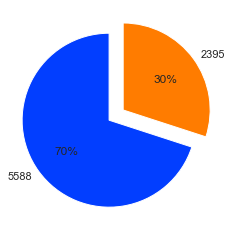

In [4]:
# Split the data into train (70%) and test (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)
#define data
data = [X_train.shape[0],X_test.shape[0] ]
labels = [data[0], data[1]]
#define Seaborn color palette to use
colors = sns.color_palette('bright')[0:2]
#create pie chart
plt.pie(data, labels = labels, colors = colors,startangle=90, 
        autopct='%1.f%%',explode=(0.1,0.1))
plt.show()

In [5]:
# declare the evaluation metrics that i am going to use
metrics = { 'mse': "neg_mean_squared_error",
           'mae': "neg_mean_absolute_error",
           "r2" : "r2"
         }
# declare how much is the K parameter of the cross validation with K-fold 
n_cv = 10

## Predicting intervals with Random Forest Regressor

I tested random forest because it's reduce the probability of overfitting and since the model is tree method build using a bagging algorithm, i thought that could be a good candidate to understand better the underlying behaviour of the delivery with such a limited sample

You can check the Scikit-learn documentation here  <https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html>



### Training with cross-validation

You can check the documentation of the function cross_validation that we use to apply cross-validation with 10 folds here

<https://scikit-learn.org/stable/modules/cross_validation.html>

Mean test R2 of the training with cross validation: 0.441 (0.034)
Mean test MSE of the training with cross validation: -676.590 (57.633)
Mean test MAE of the training with cross validation: -19.635 (0.535)


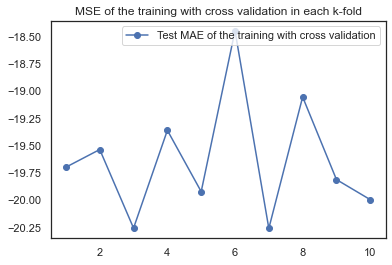

In [6]:
regr = RandomForestRegressor(n_jobs=-1,
                             n_estimators=500,
                             max_depth=6,
                             min_samples_leaf=0.01,
                             min_samples_split=0.01,
                            )
scores = train_metrics(X = X_train,y = y_train,n_cv=n_cv, metrics = metrics, model = regr)

#### train and report test metrics

1.0
This the % of orders that will arrive on time or before the predicted arrival time: 0.5841
The mean squared error (MSE) on test set: 667.4149
The mean absolute error (MAE) on test set: 19.5670
count    2395.000000
mean       19.567045
std        16.872004
min         0.000588
25%         8.172386
50%        15.412086
75%        26.350766
max       144.391245
Name: total_minutes, dtype: float64


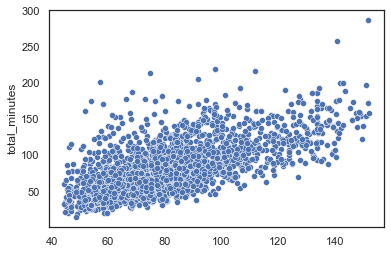

In [7]:
model,y_pred, error = show_test_metrics(X_train,y_train,y_test,model = regr)

count    2395.000000
mean       19.567045
std        16.872004
min         0.000588
25%         8.172386
50%        15.412086
75%        26.350766
max       144.391245
Name: total_minutes, dtype: float64


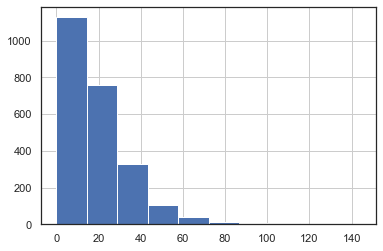

In [8]:
print(error.describe())
error.hist();

count    996.000000
mean      23.566467
std       22.176020
min        0.031797
25%        7.902492
50%       16.315518
75%       33.960206
max      144.391245
Name: total_minutes, dtype: float64


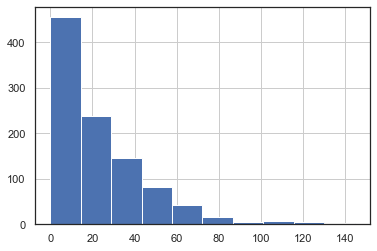

In [9]:
# for me it is a big problem when my estimate is less than the real time, that is, when the subtraction of predicted with actual arrival time is negative
error = (y_pred-y_test)
# only the error of late arrivals
print(abs(error[error<0]).describe())
abs(error[error<0]).hist();

## Predicting intervals with Gradient Boosting Regression with quantils

I used GBR to predict intervals on 50% and 90% and test it both. I test the error in two ways:


* Using the MSE and MAE as evaluation metrics

* Using only the error when the the prediction time to delyver is below the actual arrival time. I did this since in the real case scenario for Cornershop a prediction error below the actual arrival time (that is, arriving later than predicted) is much worse than an error above the actual arrival time (arriving earlier than predicted) as long as these arrivals are not in too great a time interval with respect to the predicted


<https://tech.instacart.com/how-instacart-delivers-on-time-using-quantile-regression-2383e2e03edb>

<https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_quantile.html#sphx-glr-auto-examples-ensemble-plot-gradient-boosting-quantile-py>

<https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor>

#### train with cross-validation

<https://scikit-learn.org/stable/modules/cross_validation.html>

#### Train model and predict on the test data to report metrics

Mean test R2 of the training with cross validation: 0.445 (0.037)
Mean test MSE of the training with cross validation: -671.390 (60.709)
Mean test MAE of the training with cross validation: -18.726 (0.486)


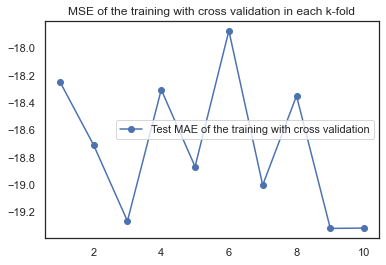

In [10]:
gbr_params = dict(
    learning_rate=0.1,
    n_estimators=150,
    max_depth=2,
    min_samples_leaf=0.01,
    min_samples_split=0.01,
)
gbr  = GradientBoostingRegressor(loss="quantile", alpha=0.5 , **gbr_params)
scores = train_metrics(X = X_train,y = y_train,n_cv=n_cv, metrics = metrics, model = gbr)

In [11]:
all_models = {}
for alpha in [0.5, 0.90]:
    gbr = GradientBoostingRegressor(loss="quantile", alpha=alpha, **gbr_params)
    all_models["q %1.2f" % alpha] = gbr.fit(X_train, y_train)

### Quantile 50

This the % of orders that will arrive on time or before the predicted arrival time: 0.4935
The mean squared error (MSE) on test set: 675.0241
The mean absolute error (MAE) on test set: 18.8836


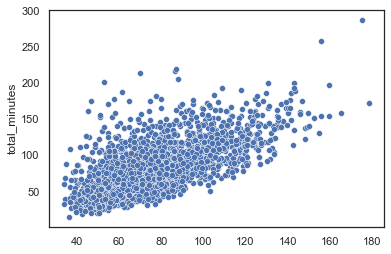

In [12]:
y_med = all_models["q 0.50"].predict(X_test)
print("This the % of orders that will arrive on time or before the predicted arrival time: {:.4f}".format(sum((y_med>=y_test))/ len(y_test)))
mse = mean_squared_error(y_test,y_med )
mae = mean_absolute_error(y_test, y_med)
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
print("The mean absolute error (MAE) on test set: {:.4f}".format(mae))
sns.scatterplot(y=y_test, x=y_med,legend=True);

count    2395.000000
mean       18.883597
std        17.848442
min         0.009552
25%         6.925169
50%        14.007699
75%        24.890134
max       148.539452
Name: total_minutes, dtype: float64


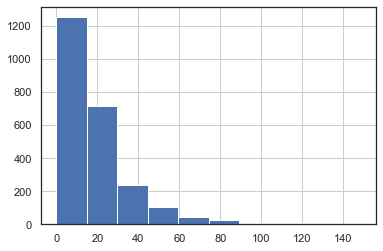

In [13]:
error = abs(y_med-y_test)
print(error.describe())
error.hist();

count    2395.000000
mean       -4.946831
std        25.511266
min      -148.539452
25%       -17.123706
50%        -0.247347
75%        12.359768
max        52.756373
Name: total_minutes, dtype: float64


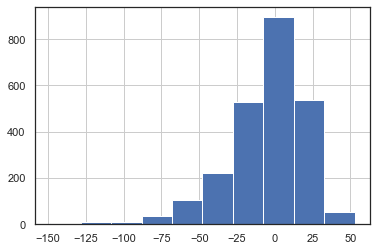

In [14]:
# for me it is a big problem when my estimate is less than the real time, that is, when the subtraction of predicted with actual arrival time is negative
error = (y_med-y_test)
print(error.describe())
error.hist();

count    1213.000000
mean       23.525917
std        22.311847
min         0.009552
25%         7.529148
50%        16.924099
75%        32.828967
max       148.539452
Name: total_minutes, dtype: float64


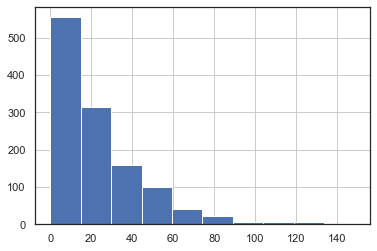

In [15]:
# doing the analysis only for the late arrivals
print(abs(error[error<0]).describe())
abs(error[error<0]).hist();

### Quantile 90

This the % of orders that will arrive on time or before the predicted arrival time: 0.8898
The mean squared error (MSE) on test set: 1667.1968
The mean absolute error (MAE) on test set: 36.1046


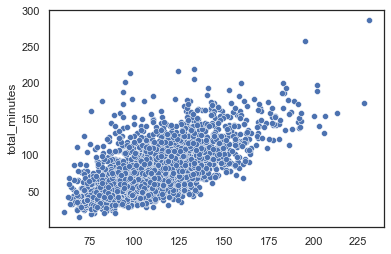

In [16]:
y_upper = all_models["q 0.90"].predict(X_test)
print("This the % of orders that will arrive on time or before the predicted arrival time: {:.4f}".format(sum((y_upper>=y_test))/ len(y_test)))
mse = mean_squared_error(y_test,y_upper )
mae = mean_absolute_error(y_test, y_upper)
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
print("The mean absolute error (MAE) on test set: {:.4f}".format(mae))
sns.scatterplot(y=y_test, x=y_upper,legend=True);

count    2395.000000
mean       36.104581
std        19.073751
min         0.079206
25%        21.275122
50%        36.552917
75%        49.085037
max       116.408265
Name: total_minutes, dtype: float64


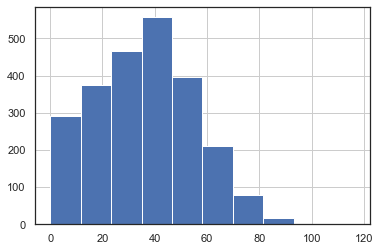

In [17]:
error = abs(y_upper-y_test)
print(error.describe())
error.hist();

count    264.000000
mean      21.068729
std       20.628015
min        0.079206
25%        6.759900
50%       16.132360
75%       28.354981
max      116.408265
Name: total_minutes, dtype: float64


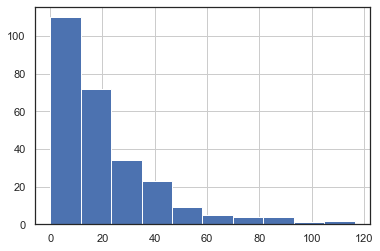

In [18]:
# for me it is a big problem when my estimate is less than the real time, that is, when the subtraction of predicted with actual arrival time is negative
error = (y_upper-y_test)
# only the error of late arrivals
print(abs(error[error<0]).describe())
abs(error[error<0]).hist();

### Conclusions:

As we can see on the results and even when the MAE and MSE are better in general for GBR Quantile with alpha 50%, **we will choose alpga with 90% because 89% of the orders will arrive on time or early**, while with alpha 50% only 49% will and **for the business case of Cornershop is much worse a delyver a few minutes late than a few minutes earlier**

Having take that decision, we will report the MAE and MSE for all the test sample as "general" and the MAE and MSE for only the late arrivals on the test sample as "late arrivals". For late arrivals we will only measure MAE because all the error is only in one direction, so MSE lost his propose:

 * General MAE : 36.1
 * General MSE : 1667.2
 * Late arrivals MAE : 21
 
It's importante to notice that only 5.5% of the orders are expected to arrive 16 minutes late or more with this estimation :)

## Scikit-Learn Interface for XGboost

Using the cost functions mae and mse  from scikit-learn out of the box

<https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html>

<https://machinelearningmastery.com/xgboost-for-regression/>

#### train model with cross-validation

Mean test R2 of the training with cross validation: 0.463 (0.042)
Mean test MSE of the training with cross validation: -648.705 (56.588)
Mean test MAE of the training with cross validation: -19.182 (0.434)


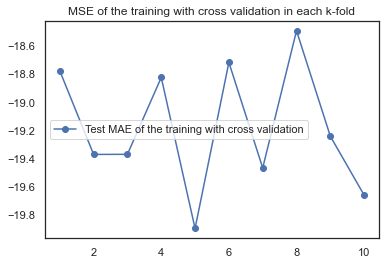

In [19]:
reg = XGBRegressor(
    tree_method="hist",
    eval_metric=mean_absolute_error,
    learning_rate=0.3,
    n_estimators=100,
    max_depth=2,
)

scores = train_metrics(X = X_train,y = y_train,n_cv=10, metrics = metrics, model = reg)

#### Train model and predict on the test data to report metrics

1.0
This the % of orders that will arrive on time or before the predicted arrival time: 0.5779
The mean squared error (MSE) on test set: 650.3336
The mean absolute error (MAE) on test set: 19.2333
count    2395.000000
mean       19.233311
std        16.749044
min         0.001492
25%         7.671312
50%        15.203153
75%        26.486637
max       143.759687
Name: total_minutes, dtype: float64


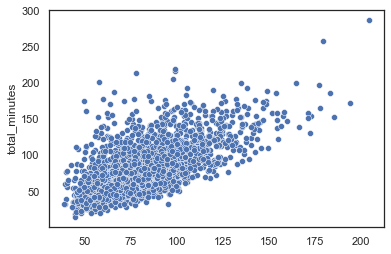

In [20]:
model,y_pred, error = show_test_metrics(X_train,y_train,y_test,model = reg)

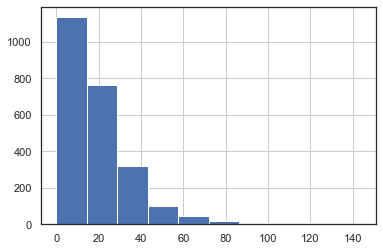

In [21]:
error.hist();

count    1011.000000
mean       23.069801
std        21.872321
min         0.001492
25%         6.967202
50%        16.133837
75%        32.797654
max       143.759687
Name: total_minutes, dtype: float64


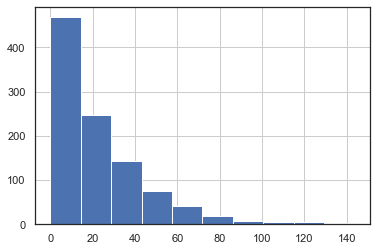

In [22]:
# for me it is a big problem when my estimate is less than the real time, that is, when the subtraction of predicted with actual arrival time is negative
error = (y_pred-y_test)
# only the error of late arrivals
print(abs(error[error<0]).describe())
abs(error[error<0]).hist();

## Using robust scaler on the numeric variables before use SVR

i used this scaler because is robust with outliers and i did not use it before because Gradient Boosting and Random Forest algorithms already deals well with non scaled variables but not Support vectors algorithms

In [23]:
#qt = QuantileTransformer(n_quantiles=10, random_state=0,output_distribution='uniform')
qt = RobustScaler()
cols= ['UN','picking_speed', 'order_stores_distance']
scaled = pd.DataFrame(qt.fit_transform(X_train[cols]),columns=cols, index = X_train.index.values)
print(scaled.shape)
X_train = pd.merge(X_train,scaled,left_index= True , right_index= True, suffixes= ('','_scaled'),how='left')
X_train.drop(cols, axis=1, inplace=True)
print(X_train .shape)
scaled = pd.DataFrame(qt.transform(X_test[cols]),columns=cols, index = X_test.index.values)
print(scaled.shape)
X_test = pd.merge(X_test,scaled,left_index= True , right_index= True, suffixes= ('','_scaled'),how='left')
X_test.drop(cols, axis=1, inplace=True)
print(X_test .shape)

(5588, 3)
(5588, 9)
(2395, 3)
(2395, 9)


## Suppor vector Regression using non-linear Kernels

<https://scikit-learn.org/stable/auto_examples/svm/plot_svm_regression.html>

#### Train with cross-validation

Mean test R2 of the training with cross validation: 0.449 (0.043)
Mean test MSE of the training with cross validation: -666.356 (65.864)
Mean test MAE of the training with cross validation: -18.615 (0.549)


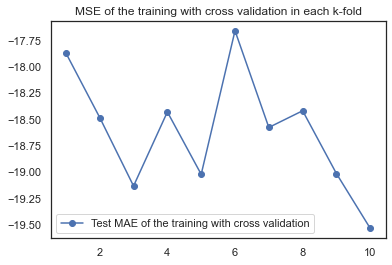

In [24]:
svr_rbf = SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1)
scores_rbf = train_metrics(X = X_train,y = y_train,n_cv=10, metrics = metrics, model = svr_rbf)

#### Train model and predict on the test data to report metrics

1.0
This the % of orders that will arrive on time or before the predicted arrival time: 0.4939
The mean squared error (MSE) on test set: 681.0158
The mean absolute error (MAE) on test set: 18.9589
count    2395.000000
mean       18.958922
std        17.936259
min         0.022738
25%         6.792136
50%        14.406990
75%        25.099243
max       150.001575
Name: total_minutes, dtype: float64


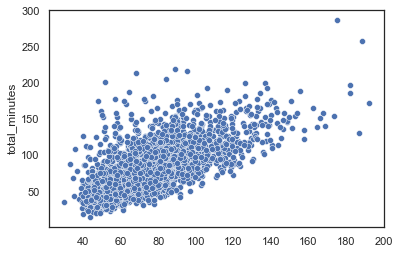

In [25]:
model,y_pred, error = show_test_metrics(X_train,y_train,y_test,model = svr_rbf)

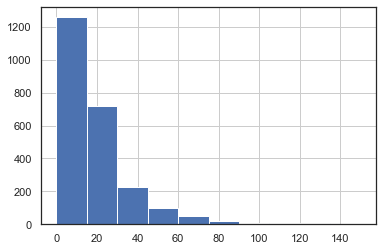

In [26]:
error.hist();

count    1212.000000
mean       23.709797
std        22.344416
min         0.022738
25%         7.455177
50%        16.736224
75%        32.921203
max       150.001575
Name: total_minutes, dtype: float64


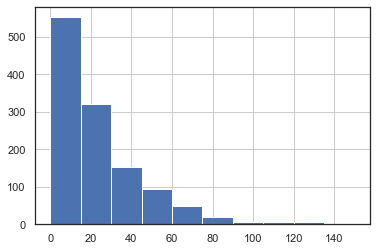

In [27]:
# for me it is a big problem when my estimate is less than the real time, that is, when the subtraction of predicted with actual arrival time is negative
error = (y_pred-y_test)
# only the error of late arrivals
print(abs(error[error<0]).describe())
abs(error[error<0]).hist();